<center>
    
    Compression of permutation-invariant images
    
    Author: Daniel Coble
    
    Status: Work in progress
</center>

This problem is coming up in my work with Rubik's cube solvers. In general, data for heuristics can be represented in a multidimensional array. Compression would be difficult since each element has very little to do with its neighbors. However, one trick is that the array is permutation-invariant, i.e. the ordering along each axis does not matter. With that information, the dimensions can be re-ordered to produce large-scale patterns across the array, which can then be compressed. Here, I test the idea with two-dimensional 100x100 arrays filled with random elements between 0 and 1. The degree of similarity between two row or column vectors can be tested by a dot product. From there, an idea of a dimensional 'energy' can be created by summing all dot products multiplied by the distance between the two vectors. Testing every possible permutation to see if it reduces energy, we can then find a minimum across rows and columns. Admittedly, this is a pretty ham-fited way to do this, and lacks any theoretical grounding, but it should be enough to see whether this idea is worth persuing. Results are presented numerically with compression loss and visually with array plots.

starting row energy: 8204592.800848
starting column energy: 8214800.982623
final row energy: 7989423.692697
final column energy: 7968222.977364


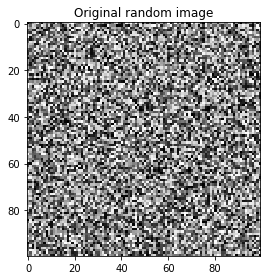

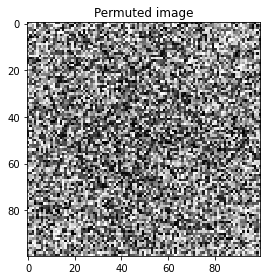

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# distance matrix -- 0s along diagonal, 1s in diagonals above and below, 2s above/below that, etc.
dist = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        dist[i,j] = abs(i-j)

def row_energy(arr):
    a = arr @ arr.T
    b = a * dist
    return np.sum(b)

def col_energy(arr):
    a = arr.T @ arr
    b = a * dist
    return np.sum(b)

arr = np.random.rand(100, 100)
arrOriginal = np.copy(arr)

re = row_energy(arr)
ce = col_energy(arr)

print("starting row energy: %f"%re)
print("starting column energy: %f"%ce)


i = 0; j = 1;
p = 0; # count of number of permutations
d = 0 # total number of iterations
i_max = i; j_max = j
while(i!=99 and j!=100):
    prop_arr = np.copy(arr)
    prop_arr[[i,j],:] = prop_arr[[j,i],:]
    prop_re = row_energy(prop_arr)
    if(prop_re < re):
        i = 0; j = 1; p += 1
        re = prop_re
        arr = prop_arr
    j += 1
    if(j==100):
        i += 1
        j = i+1
    # monitoring
    d += 1
    if(i > i_max):
        i_max = i
        j_max = 0
    if(i == i_max and j > j_max):
        j_max = j
#     if(d % 10000 == 0):
#         print("energy: %f  permutations: %d  iterations: %d  i_max: %d  j_max: %d"%(re, p, d, i_max, j_max))

i = 0; j = 1;
p = 0; # count of number of permutations
d = 0 # total number of iterations
i_max = i; j_max = j
while(i!=99 and j!=100):
    prop_arr = np.copy(arr)
    prop_arr[:,[i,j]] = prop_arr[:,[j,i]]
    prop_ce = col_energy(prop_arr)
    if(prop_ce < ce):
        i = 0; j = 1; p += 1
        ce = prop_ce
        arr = prop_arr
    j += 1
    if(j==100):
        i += 1
        j = i+1
    # monitoring
    d += 1
    if(i > i_max):
        i_max = i
        if(j > j_max):
            j_max = j
#     if(d % 10000 == 0):
#         print("energy: %f  permutations: %d  iterations: %d  i_max: %d  j_max: %d"%(ce, p, d, i_max, j_max))

print("final row energy: %f"%re)
print("final column energy: %f"%ce)

plt.figure()
plt.title("Original random image")
plt.imshow(arrOriginal, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Permuted image")
plt.imshow(arr, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
plt.tight_layout()
plt.show()